#  Calculating the synchronization timescale t_sync at ZAMS

In this notebook, we test if the synchronization timescale is short relative to the mainsequence timescale for our best fitting model

In [337]:
import numpy as np
import matplotlib.pyplot as plt
import os

import astropy.units as u
import astropy.constants as const
import mesaPlot as mp

home_dir = os.path.expanduser("~")
data_root_dir    = home_dir + '/ceph/ksharpe/results/' #'/ceph/MESAoutput/ksharpe_proj/'
inlist_dirs = ['dense_mass_hastings_grid', 'dens_mass_grid_run' 'dense_mass_div3winds_grid',  'CHE_x3winds']

def Kepler(m1 = 1*u.Msun, m2 = 1*u.Msun, P = 1*u.day):
    m1 = m1.to(u.kg)
    m2 = m2.to(u.kg)
    P = P.to(u.s)
    a = ( (const.G * (m1 + m2)) *  (P**2) / (2*np.pi)**2 )**(1/3)
    return a.to(u.Rsun)


## Import necessary model data 
for t_sync calculations from models, save as separate table

('model_number', 'star_age', 'star_mass', 'star_mdot', 'log_dt', 'log_total_angular_momentum', 'he_core_mass', 'log_Teff', 'log_L', 'log_R', 'surf_avg_v_rot', 'surf_avg_v_crit', 'surf_avg_Lrad_div_Ledd', 'rotational_mdot_boost', 'center_h1', 'center_he4', 'center_c12', 'surface_h1', 'surface_he4', 'surface_c12', 'surface_n14', 'surface_o16', 'surface_ne20', 'surface_mg24', 'model_number.1', 'age', 'period_days', 'rl_1', 'rl_2', 'lg_wind_mdot_1', 'J_orb', 'J_spin_1', 'Jdot')
ZAMS age = 52150.075753848825 


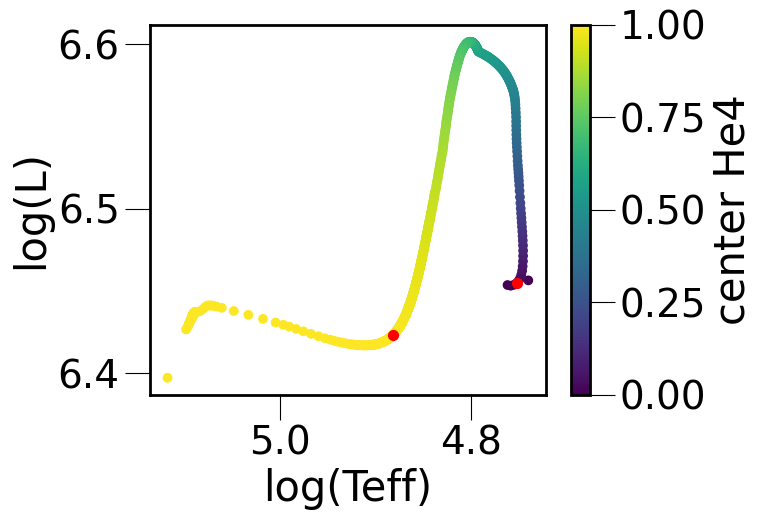

subdir =  336
P_ZAMS =  3.6 M_ZAMS =  167.46744815418376


In [365]:
# Get a list of all the folders in the directory
dir = data_root_dir + '/dense_mass_hastings_grid/'
 
#folder with best-fit model
subdir = 336 # 153 #
            
# for subdir in np.linspace(330, 360, 10, dtype = int):
    
m=mp.MESA()
m.loadHistory(f = dir + str(subdir) + '/LOGS1')

# ALL data column names
print(m.hist.data.dtype.names)



# We adopt the first moment that X drops below 0.74 as ZAMS
def find_ZAMS(data):
    return next((i for i, x in enumerate(data) if x < 0.735), None)


ZAMS_i = find_ZAMS(m.hist.center_h1)
print(f'ZAMS age = {m.hist.star_age[ZAMS_i]} ')

# We adopt the time when center_he4 is 0.99 as the end of the MS
def find_end_of_MS(data):
    return next((i for i, x in enumerate(data) if x > 0.99), None)

TAMS_i = find_end_of_MS(m.hist.center_he4)

# #plot HR diagram (to show ZAMS and TAMS makes sense)
plt.scatter(m.hist.log_Teff, m.hist.log_L , c =  m.hist.center_he4 )
plt.scatter(m.hist.log_Teff[ZAMS_i], m.hist.log_L[ZAMS_i], c='r', s = 50)
plt.scatter(m.hist.log_Teff[TAMS_i], m.hist.log_L[TAMS_i], c='r', s = 50)
plt.colorbar(label = 'center He4')
plt.gca().invert_xaxis() 
plt.xlabel('log(Teff)')
plt.ylabel('log(L)')
plt.show()

print('subdir = ', subdir)
print('P_ZAMS = ', m.hist.period_days[0], 'M_ZAMS = ', m.hist.star_mass[ZAMS_i])



## Hurley et al 2002 - Radiative envelopes *(Fiducial)*
Hut radiative in MESA

[Hurley et al. 2002, eq 44](https://articles.adsabs.harvard.edu/pdf/2002MNRAS.329..897H), (but timescale for synchronization was derived by [Zahn (1975)](https://articles.adsabs.harvard.edu//full/1975A%26A....41..329Z/0000331.000.html) )

\begin{equation}
\frac{1}{\tau_{sync}} = 52^{5/3} \left( \frac{GM}{R^3} \right)^{1/2} \frac{MR^2}{I} q^2_2 (1 + q_2)^{5/6} E_2 \left(\frac{R}{a} \right)^{17/2}
\end{equation}

(same as [eq. 2 in de Mink et al. 2009](https://www.aanda.org/articles/aa/pdf/2009/13/aa11439-08.pdf) )


M and R are the mass and radius of the star, and a the separation

Here, $q_2 = \frac{M_{companion}}{M_{star}}$ (=1 for us)

E2 is a second-order tidal coefficient which can be fitted to values given by Zahn (1975),
$E_2 = 1.592 \times 10^{-9} M^{2.84} $

$I \approx (2/5) M R^2$ is the moment of inertia of the perturbed star

Substituting all this we get

\begin{equation}
\frac{1}{\tau_{sync}} = (5/2) \cdot 5 \cdot 2^{5/3} \cdot E_2 \cdot (GM)^{1/2} R^{7} a^{-8.5}
\end{equation}

In [367]:
# Simplified version
def tau_sync_Hurley_rad(Mstar = 1*u.Msun, R=1*u.Rsun, a=1 *u.Rsun):
    E_2 = (1.592*1e-9 * Mstar**2.84).value #unitless coefficient
    grav_const = const.G.to(u.Rsun**3/u.Msun/u.year**2) # In astro units
    
    return 1/((5/2.) * 5* 2**(5/3) * E_2  * (grav_const * Mstar)** 0.5 * R**7 * a**(-8.5))

# For best fitting model
a_ZAMS =  Kepler(m1 = m.hist.star_mass[ZAMS_i] * u.Msun, m2 =m.hist.star_mass[ZAMS_i] * u.Msun,
                 P = m.hist.period_days[ZAMS_i] * u.day)

print('a_ZAMS', a_ZAMS, 'P_ZAMS', m.hist.period_days[ZAMS_i] * u.day)

t_sync_rad = tau_sync_Hurley_rad(m.hist.star_mass[ZAMS_i] * u.Msun, 10**m.hist.log_R[ZAMS_i] * u.Rsun, a_ZAMS)
print(f'Synchronization timescale for best fitting model {np.round(t_sync_rad,5)}, under the assumption of radiative damping')

# Main sequence lifetime for best fitting model
MS_lifetime = (m.hist.star_age[TAMS_i] - m.hist.star_age[ZAMS_i] )*u.year

print(f'This is {np.round(t_sync_rad/MS_lifetime, 8) *100} % of the main sequence lifetime')


a_ZAMS 68.64919110739824 solRad P_ZAMS 3.6001139835460303 d
Synchronization timescale for best fitting model 234.59029 yr, under the assumption of radiative damping
This is 0.008467 % of the main sequence lifetime


# Yoon, Woosley, Langer 2010

\begin{equation}
\tau_{sync} = f_{sync} \frac{1.44\times 10^{1.6}}{q(1+q)^{3/8}} \left(\frac{L_\odot}{L}\right)^{1/4} \left(\frac{M_\odot}{M}\right)^{1/8} \left(\frac{R}{R_\odot}\right)^{9/8} \left(\frac{d}{R}\right)^{33/8} years
\end{equation}

[YWL 2010, equation 3](https://iopscience.iop.org/article/10.1088/0004-637X/725/1/940/pdf)

following Wellstein (2001) (see also Detmers et al. 2008). We assume a synchronization timescale according to Tassoul (1987, 2000) who considered tidally driven meridional circulations as the main mechanism for tidal dissipation

we again adopt $q = 1$

In [361]:
#Yoon, Woosley, Langer 2010 
def tau_YWL2010(f_sync = 1, L = 1*u.Lsun, M = 1*u.Msun, R = 1*u.Rsun, a =1*u.Rsun):
    tau = ((f_sync * (1.44 * 10**(1.6)) * (1/L)**(1./4) * 
            (1/M)**(1./8) * (R)**(9./8) * (a/R)**(33/8)) ).value
    return tau * u.yr
    
t_sync_YWL = tau_YWL2010(L = 10**m.hist.log_L[ZAMS_i]*u.Lsun, 
            M = m.hist.star_mass[ZAMS_i]*u.Msun, 
            R = 10**m.hist.log_R[ZAMS_i]*u.Rsun, 
            a = a_ZAMS)

print('t_sync_YWL', t_sync_YWL)

print(f'Synchronization timescale for best fitting model {np.round(t_sync_YWL)}, under the assumption of meridional circulation')
print(f'This is {np.round(t_sync_YWL/MS_lifetime, 4) *100} % of the main sequence lifetime')


t_sync_YWL 5099.190787479958 yr
Synchronization timescale for best fitting model 5099.0 yr, under the assumption of meridional circulation
This is 0.18 % of the main sequence lifetime


# Hurley et al 2002 - Convective envelopes 
## (or “turbulent viscosity” )
Hut convective in MESA, Eq 27  in [Hurley et al. 2002](https://articles.adsabs.harvard.edu/pdf/2002MNRAS.329..897H),  
Synchronization timescale as derived by [Zahn 1977 eg 6.1](https://articles.adsabs.harvard.edu/pdf/1977A%26A....57..383Z) :

\begin{equation}
\frac{1}{\tau_{sync}} = 3\left(\frac{k}{t_{F}}\right)_c  \frac{M R^2}{I} q_2^2 \left(\frac{R}{a}\right)^6
\end{equation}

with $t_{F}$ the time-scale on which significant changes in the orbit take place through tidal evolution.
and $k$ is the the apsidal motion constant of the star, which takes into account the structure of the star.

Assuming again $I \approx (2/5) M R^2$ is the moment of inertia of the perturbed star, and setting $q=1$, we can simplify to:

\begin{equation}
\frac{1}{\tau_{sync}} = 15/2 \left(\frac{k}{t_{F}}\right)_c  \left(\frac{R}{a}\right)^6
\end{equation}

 [de Mink et al. 2009](https://www.aanda.org/articles/aa/full_html/2009/13/aa11439-08/aa11439-08.html) (eq. 1) approximate this as:

\begin{equation}
\tau_{sync} = f_{turb}\times q^{-2} \left(\frac{a}{R}\right)^{6} yr
\end{equation}

With $f_{turb} \approx 1$, following [Zahn 1977 eg 6.1](https://articles.adsabs.harvard.edu/pdf/1977A%26A....57..383Z), who showed that this adequately explains the observed orbital period below which tides lead to synchronization due to the strong dependence of $R/a$'





In [363]:
"""
Hurley et al 2002 from Hut
values of k for realistic stars are 0.1-0.01, 
more centrally condensed star structure means lower k
tau is a small lag time introduced via dissipation, 
such that the amplitude and direction of the tides are slightly changed
t_tide = R^3/(G M tau)
assuming spherical moment of inertia
"""
# def tau_hut(tau, k, M, R, a):
#     T_timescale = np.divide(np.power(R,3), M)/const.G/tau
#     return np.power(np.multiply(3*np.divide(k, T_timescale), 
#                                 np.power(np.divide(R, a), 6))*5/2, 
#                     -1).to(u.year) 
#test
# tau_hut(1*u.second, 0.1, 1*u.Msun, 1*u.Rsun, semimajor(1*u.Msun, 1*u.year))

#Zahn 1977
def tau_zahn_conv_simpl(R = 1*u.Rsun, a = 1*u.Rsun, f_turb = 1.):
    return (f_turb * (a/R)**6)*u.yr


print('R_ZAMS=', 10**m.hist.log_R[ZAMS_i] * u.Rsun, ' a_ZAMS', a_ZAMS, 'P_ZAMS = ', m.hist.period_days[ZAMS_i])
print('MS_lifetime', MS_lifetime)
t_sync_conv = tau_zahn_conv_simpl(10**m.hist.log_R[ZAMS_i] * u.Rsun, a_ZAMS)

print(f'Synchronization timescale for best fitting model {np.round(t_sync_rad,3)}, under the assumption of turbulent viscosity damping')
print(f'This is {np.round(t_sync_conv/MS_lifetime, 4) *100} % of the main sequence lifetime')


R_ZAMS= 17.58309355500752 solRad  a_ZAMS 68.64919110739824 solRad P_ZAMS =  3.6001139835460303
MS_lifetime 2770565.8912758734 yr
Synchronization timescale for best fitting model 5.14 yr, under the assumption of turbulent viscosity damping
This is 0.13 % of the main sequence lifetime


## Zahn 2008 - weak friction approximation Viscosity

[Zahn 2008 eq 2.5](https://arxiv.org/pdf/0807.4870.pdf )

(seems very similar to Hut treatment for convective envelopes)
\begin{equation}
\frac{1}{\tau_{sync}} = \frac{1}{t_{diss}} \left(\frac{\omega - \Omega}{\omega}\right)  \frac{M R^2}{I} q^2 \left(\frac{R}{a}\right)^6
\end{equation}

$\omega$ is the rotation angular velocity of the perturbed star, while $\Omega$ is the orbital angular velocity. 

 $t_{diss}= R^2/ < \nu >$ is the viscous dissipation time, where $<\nu>$ is a suitable average of the kinematic viscosity.

Assuming again $I \approx (2/5) M R^2$ is the moment of inertia of the perturbed star, adopting againg $q\approx 1$ in our case, and defining $\beta = \omega/\Omega$ we get:

\begin{equation}
\frac{1}{\tau_{sync}} =  5/2 < \nu > \left(\beta - \frac{1}{\beta}\right) R^4 \left(\frac{1}{a}\right)^6
\end{equation}


Fig. 3 of Zahn (2008), who reproduces results from Penev et al. (2007), gives a summary of the
range in expected viscosity values:
$<\nu> ∼ 10^{11} − 10^{13}cm^2/s.$

In [346]:
################
# First to caculate beta
# Orbital angular velocity (in 1/day units)
Omega = 2 * np.pi / (m.hist.period_days[ZAMS_i] * u.day)

# Calculate omega star
v_surf = m.hist.surf_avg_v_rot[ZAMS_i] * (u.km / u.s)
omega = v_surf.to(u.Rsun / u.yr) / (10 ** m.hist.log_R[ZAMS_i] * u.Rsun) #v_surf / radius

beta = omega / Omega.to(u.yr ** -1)
# print(f'beta = {beta}')

####################
#Zahn 1977
def tau_zahn_conv(v_avg = 1*(u.Rsun**2/u.year), beta = 1, R = 1*u.Rsun, a = 1*u.Rsun):
    return 1. / ( (5/2) * v_avg * (beta - 1./beta) * R** 4 / a**6)

A = beta - 1./beta
print('beta - 1/beta', A)


v_min = 1e13 * u.cm**2 / u.s
B = v_min.to(u.Rsun**2/u.year)
print('<vmin>', B)


C = (10 ** m.hist.log_R[ZAMS_i] * u.Rsun)**4 /  a_ZAMS**6 
print('R^4/a^6', C)

print(A * B * C)


t_conv = tau_zahn_conv(v_avg = v_min.to(u.Rsun**2/u.year), beta = beta, 
                       R = 10**m.hist.log_R[ZAMS_i] * u.Rsun, a = a_ZAMS)


print(f'Synchronization timescale for best fitting model {np.round(t_conv)}, under the assumption of turbulent viscosity damping, with more precise fturb')
print(f'This is {np.round(t_conv/MS_lifetime) *100} % of the main sequence lifetime')

beta - 1/beta 0.025593432595670706
<vmin> 0.06520185631157652 solRad2 / yr
R^4/a^6 9.991665190907822e-06 1 / solRad2
1.6673484522617408e-08 1 / yr
Synchronization timescale for best fitting model 23990186.0 yr, under the assumption of turbulent viscosity damping, with more precise fturb
This is 900.0 % of the main sequence lifetime


In [21]:
# zahn 2008
# assuming spherical moment of inertia
def tau_zahn_visc(t_diss, P, Omega, M, R, a):
    omega = 2*np.pi*np.power(P, -1)
    t_diss * (omega - Omega)/omega 
    return (t_diss*np.multiply(np.divide(omega, np.abs(omega-Omega)), 
                              2/5*np.power(np.divide(a, R), 6))).to(u.year)
    
    
# test
tau_zahn_visc(1*u.s, 1*u.year, 10/u.s, 1*u.Msun, 1*u.Rsun, Kepler(1*u.Msun, 1*u.year))

<Quantity 0.02494896 yr>

# Repeat exercise for all models


In [347]:

# Get a list of all the folders in the directory
dir = data_root_dir + '/dense_mass_hastings_grid/'

verbose = False

radiative_sync_times = np.array([])
convective_sync_times = np.array([])
MS_lifetimes = np.array([])
for subdir in os.listdir(dir):
    if subdir in ['photos', 'LOGS', 'LOGS1']:
        continue
    if os.path.isdir(os.path.join(dir, subdir)):
        try:
            # print(subdir)
            m=mp.MESA()
            m.loadHistory(f = dir + str(subdir) + '/LOGS1')
            
            # Find start and end of MS
            ZAMS_i = find_ZAMS(m.hist.center_h1)
            TAMS_i = find_end_of_MS(m.hist.center_he4)
            if ZAMS_i is not None and TAMS_i is not None:
                MS_lifetime = (m.hist.star_age[TAMS_i] - m.hist.star_age[ZAMS_i] )*u.year

                # Separation at ZAMS
                a_ZAMS =  Kepler(m1 = m.hist.star_mass[ZAMS_i] * u.Msun, m2 =m.hist.star_mass[ZAMS_i] * u.Msun,
                                P = m.hist.period_days[ZAMS_i] * u.day)

                # Synchronization timescale for a radiative envelope
                t_sync_rad = tau_sync_Hurley_rad(m.hist.star_mass[ZAMS_i] * u.Msun, 10**m.hist.log_R[ZAMS_i] * u.Rsun, a_ZAMS)
                
                # Synchronization timescale for a convective envelope
                t_sync_conv = tau_zahn_conv(10**m.hist.log_R[ZAMS_i] * u.Rsun, a_ZAMS)

                # Append to lists
                radiative_sync_times.append(t_sync_rad.value)
                convective_sync_times.append(t_sync_conv.value)
                MS_lifetimes.append(MS_lifetime.value)
                
                if verbose:
                    print(f'Mzams = {m.hist.star_mass[ZAMS_i]}, Pzams =  {m.hist.period_days[ZAMS_i]}')
                    print(f'a_ZAMS = {a_ZAMS}', ' Rzams', 10**m.hist.log_R[ZAMS_i] * u.Rsun)
                    print(f'age ZAMS = {m.hist.star_age[ZAMS_i]} , MS lifetime = {MS_lifetime}')
                    print(f'Synchronization timescale= {np.round(t_sync_rad)}, under the assumption of radiative damping')
                    print(f'This is {np.round(t_sync_rad/MS_lifetime, 2) *100} % of the main sequence lifetime')

                    continue
        except:
            print(f'Error for model {subdir}')
        else:
            continue
        
        


Error for model 274
Error for model 166
Error for model 247
Error for model 248
Error for model 437
Error for model 147
Error for model 151
Error for model 170
Error for model 73
Error for model 167
Error for model 411
Error for model 140
Error for model 142
Error for model 150
Error for model 273
Error for model 337
Error for model 388
Error for model 269
Error for model 105
Error for model 265
Error for model 77
Error for model 218
Error for model 290
Error for model 149
Error for model 109
Error for model 292
Error for model 242
Error for model 158
Error for model 243
Error for model 360
Error for model 250
Error for model 221
Error for model 244
Error for model 339
Error for model 268
Error for model 189
Error for model 311
Error for model 288
Error for model 253
Error for model 343
Error for model 95
Error for model 36
Error for model 249
Error for model 133
Error for model 291
Error for model 74
Error for model 226
Error for model 173
Error for model 390
Error for model 174
Error

Radiative sync times: max fraction of MS 121.89%, min fraction of MS 0.15%


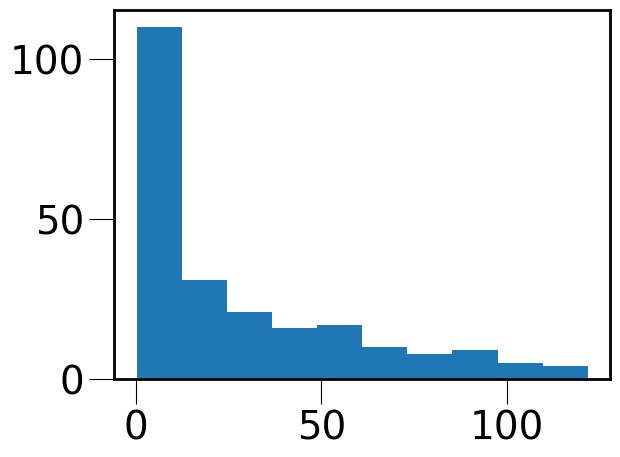

In [ ]:
# tsyncRad_tMS = np.array(radiative_sync_times)/np.array(MS_lifetimes) 
# print( tsyncRad_tMS)


print(f'Radiative sync times: max fraction of MS {np.round(np.max(tsyncRad_tMS)*100, 2)}%, min fraction of MS {np.round(np.min(tsyncRad_tMS)*100,2)}%' )

plt.hist(tsyncRad_tMS*100)
plt.show()
